In [1]:
import warnings
import numpy as np
import numba
import matplotlib
import matplotlib.pyplot as plt
from coffea.nanoevents import NanoEventsFactory

/cvmfs/cms.cern.ch/slc7_amd64_gcc10/external/py3-setuptools/60.9.3-ddcab3b6a742c72fed5554de8ccaaf18/lib/python3.9/site-packages/_distutils_hack/__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/cvmfs/cms.cern.ch/slc7_amd64_gcc10/external/py3-setuptools/60.9.3-ddcab3b6a742c72fed5554de8ccaaf18/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
# order based on reweight_card.dat order
params = ['sm','4','5','26','28','30','32','34','16','18','22','24','7','8','9']
npar = len(params)

In [3]:
fn = "VBF_SMEFTsim_topU3l_NP1_123.root"
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    events = NanoEventsFactory.from_root(fn).events()

In [4]:
@numba.jit
def compute_scaling(weights, npar):
    """Compute scaling matrix
        weights: nevents by npar*(npar+1)/2-1 array (SM point assumed 1.0)
    """
    mats = np.zeros((len(weights), npar, npar))
    mats[:, 0, 0] = 1.0
    for ievt, row in enumerate(weights):
        idx = 2*npar - 2
        for i in range(1, npar):
            halfci = row[2*i-2]
            ci = row[2*i-1]
            ai = -3 + 4*halfci - ci
            bii = 2 - 4*halfci + 2*ci
            mats[ievt, 0, i] = ai/2
            mats[ievt, i, 0] = ai/2
            mats[ievt, i, i] = bii
            for j in range(i+1, npar):
                cj = row[2*j-1]
                cij = row[idx]
                bij = 1 - ci - cj + cij
                mats[ievt, i, j] += bij / 2
                mats[ievt, j, i] += bij / 2
                idx += 1

        assert idx == len(row)
    return mats

In [5]:
mats = compute_scaling(np.array(events.LHEReweightingWeight), npar)

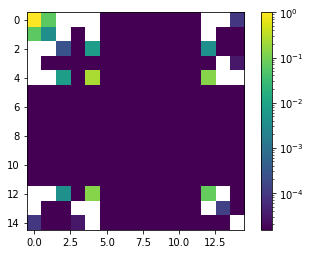

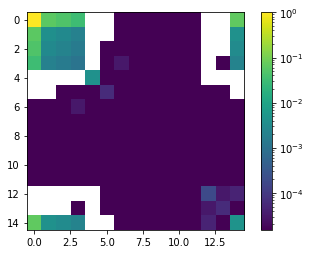

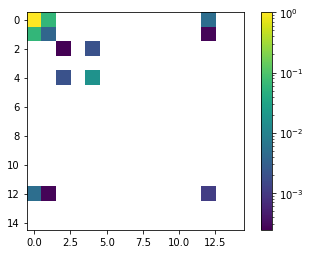

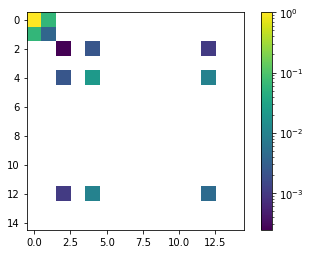

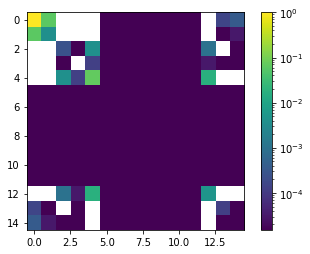

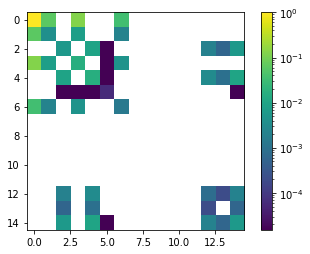

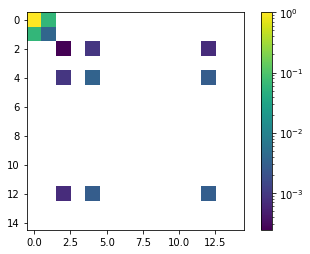

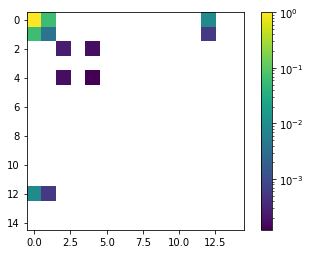

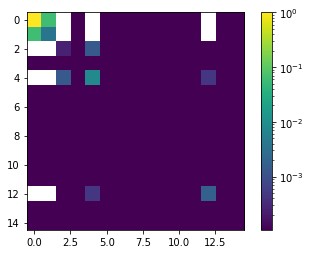

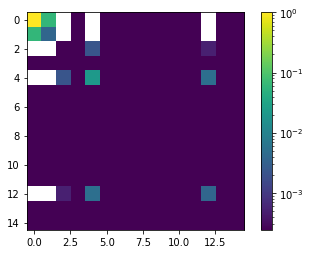

In [8]:
for i in range(0,10):
    plt.imshow(mats[i],norm=matplotlib.colors.LogNorm())
    plt.colorbar()
    plt.show()